## Consigna 1

1)	Desarrollar al menos dos modelos de clasificación (decision tree, logistic regression) que tengan como target feature categoria_socio.
* La target feature podrá asumir dos valores: 
●	Standard.
●	 Silver + Gold.

Aplicar las buenas prácticas en la construcción de modelos: dividir datos en conjunto de entrenamiento y validación, cross-validation, grid-search.

Obtener feature importance.

El objetivo es entender las diferencias entre las distintas categorías de afiliados. Cuáles son las variables más relevantes para diferenciarlos?

Las conclusiones obtenidas a partir de este modelo resultarán de gran importancia para el desarrollo de un modelo de recomendación.

### Importación de librerías y datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_procesado=pd.read_csv('../Data/df_procesado.csv')
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   float

In [3]:
df_procesado

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,especialidad_prestador_encoded_CLINICA MEDICA,especialidad_prestador_encoded_NUTRICIONISTAS(LIC.),especialidad_prestador_encoded_PEDIATRIA,edad_cat_pediatrico,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.666667,1,0.952941,0.530769,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.555556,1,0.952941,0.530769,1,0,1,...,1,0,0,1,1,0,0,0,0,1
2,4,100002,200000,0.666667,2,0.705882,0.584615,1,0,0,...,1,0,0,1,1,0,0,0,0,1
3,12,100010,200000,0.666667,7,0.505882,0.523077,1,0,1,...,1,0,0,1,1,0,0,0,0,1
4,22,100017,200000,0.666667,4,0.552941,0.538462,1,0,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2001,101548,200193,0.222222,1,0.035294,0.100000,0,1,0,...,0,0,1,1,0,0,1,0,0,1
2496,2080,101612,200193,0.111111,8,0.058824,0.161538,0,1,0,...,0,0,1,1,0,0,1,0,0,1
2497,2088,101618,200194,0.111111,9,0.035294,0.092308,1,0,0,...,0,0,1,1,0,0,1,0,0,1
2498,2327,101791,200195,0.111111,1,0.094118,0.223077,0,1,0,...,0,0,1,1,0,0,1,0,0,1


In [4]:
features_eliminar = ['id_consumo_encoded','id_prestador_encoded','id_socio_encoded','id_zona_encoded' , 'categoria_socio_gold','categoria_socio_silver']
df_procesado.drop(features_eliminar, axis = 1,inplace = True)

X = df_procesado.drop(['categoria_socio_standard'], axis = 1)
Y = df_procesado.categoria_socio_standard

X_train , X_test , y_train , y_test = train_test_split(X , Y , test_size = 0.3 , random_state=42)

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 1552 to 860
Data columns (total 24 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   calificacion_experiencia_encoded                                                   1750 non-null   float64
 1   edad_encoded                                                                       1750 non-null   float64
 2   antiguedad_encoded                                                                 1750 non-null   float64
 3   sexo_encoded_F                                                                     1750 non-null   int64  
 4   sexo_encoded_M                                                                     1750 non-null   int64  
 5   plan_encoded_a                                                                     1750 non-null   int

In [26]:
df_procesado.categoria_prestador_standard.value_counts()

0    2038
1     462
Name: categoria_prestador_standard, dtype: int64

Text(0.5, 1.0, 'Distribución de clases')

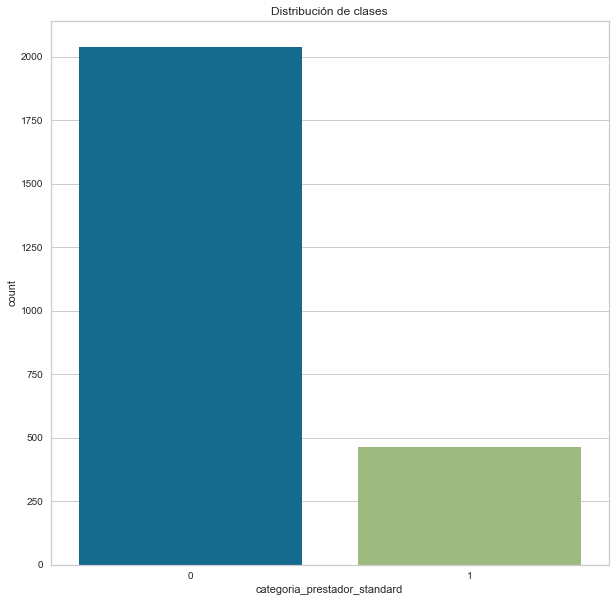

In [27]:
plt.figure(figsize = (10,10))
sns.countplot(data = df_procesado, x='categoria_prestador_standard')
plt.title("Distribución de clases")

Se utilizará GridSearchCV para optimizar los hiperparámetros de tres modelos distintos: Regresión Logística, DecisionTree y RandomForest

In [12]:
lr = LogisticRegression(random_state = 0, class_weight = 'balanced')
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')

models_parameters= {'logistic_regression': (lr,
                     {'penalty':['l1','l2'],
                     'C':[0.0001,0.001,0.01,0.1,1,10,100],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})
                     ,'decision_tree': (dt,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'n_estimators':[50,100,150,200,300],
                      'criterion': ['gini','entropy']})
                   }

In [13]:
for name, (model, params) in models_parameters.items():

    cv = GridSearchCV(model , cv = 5 , param_grid = params , n_jobs = -1, scoring = 'balanced_accuracy' )

    cv.fit(X_train , y_train)
    
    print(name)
    print(cv.best_score_)
    print(cv.best_params_)

logistic_regression
0.7125786163522013
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
decision_tree
0.8649196366177498
{'criterion': 'entropy', 'max_depth': 20}
randonforest
0.8647798742138363
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}


El mejor modelo es DecisionTreeClassifier. Se entrena el modelo con los mejores hiperparámetros

In [14]:
best_model = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced' , max_depth = 20 , criterion = 'entropy' )

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

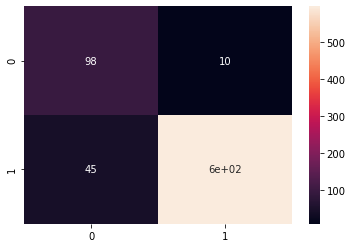

              precision    recall  f1-score   support

           0       0.69      0.91      0.78       108
           1       0.98      0.93      0.96       642

    accuracy                           0.93       750
   macro avg       0.83      0.92      0.87       750
weighted avg       0.94      0.93      0.93       750



In [15]:
cm = confusion_matrix(y_test , y_pred_test)

sns.heatmap(cm , annot = True)
plt.show()

print(classification_report(y_test , y_pred_test))

In [16]:
importance = best_model.feature_importances_
importances = pd.DataFrame({'features': X_train.columns , 'importances': importance})
importances.sort_values(by='importances',ascending=False, inplace = True)

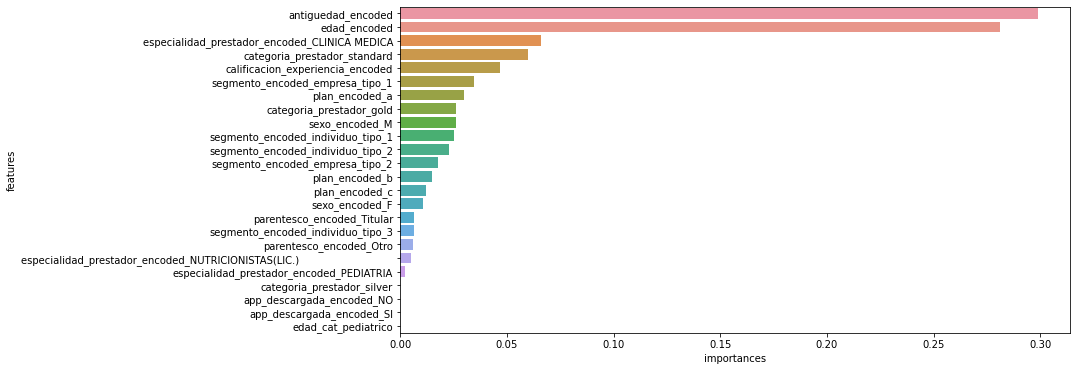

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(data=importances, y='features',x='importances')
plt.show()

In [14]:
df_procesado.columns

Index(['calificacion_experiencia_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI',
       'especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA', 'edad_cat_pediatrico',
       'categoria_prestador_gold', 'categoria_prestador_silver',
       'categoria_prestador_standard', 'categoria_socio_standard'],
      dtype='object')

### PyCaret

Se hará uso de la librería PyCaret para hacer un análisis similar y encontrar así equivalencias.

In [18]:
from pycaret.classification import *
clf = setup(df_procesado, target='categoria_socio_standard', session_id=42, fix_imbalance = True)

,Description,Value
0,session_id,42
1,Target,categoria_socio_standard
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2500, 25)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,21
8,Ordinal Features,False
9,High Cardinality Features,False


In [19]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9200,0.9518,0.9387,0.9663,0.9521,0.7075,0.7124,0.0870
xgboost,Extreme Gradient Boosting,0.9165,0.9418,0.9373,0.9635,0.9501,0.6945,0.6988,0.4070
rf,Random Forest Classifier,0.9148,0.9463,0.9394,0.9600,0.9493,0.6810,0.6863,0.1010
lightgbm,Light Gradient Boosting Machine,0.9034,0.9320,0.9360,0.9496,0.9426,0.6355,0.6374,0.4920
dt,Decision Tree Classifier,0.8525,0.7918,0.8787,0.9439,0.9099,0.5037,0.5148,0.0130
gbc,Gradient Boosting Classifier,0.8096,0.8293,0.8530,0.9168,0.8835,0.3623,0.3703,0.1220
knn,K Neighbors Classifier,0.8033,0.8869,0.8032,0.9585,0.8737,0.4434,0.4818,0.1550
ada,Ada Boost Classifier,0.7421,0.7612,0.7749,0.9078,0.8356,0.2510,0.2690,0.0730
lr,Logistic Regression,0.6809,0.7712,0.6705,0.9354,0.7808,0.2485,0.3016,0.3770
ridge,Ridge Classifier,0.6724,0.0000,0.6577,0.9379,0.7729,0.2444,0.3015,0.0110


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [20]:
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9086,0.9357,0.9329,0.9586,0.9456,0.6602,0.6626
1,0.8914,0.9781,0.8926,0.9779,0.9333,0.6443,0.6642
2,0.9200,0.9728,0.9597,0.9470,0.9533,0.6734,0.6742
3,0.9086,0.9306,0.9463,0.9463,0.9463,0.6386,0.6386
4,0.9371,0.9615,0.9527,0.9724,0.9625,0.7696,0.7711
5,0.9371,0.8966,0.9662,0.9597,0.9630,0.7554,0.7556
6,0.9143,0.9577,0.9257,0.9716,0.9481,0.7030,0.7099
7,0.9143,0.9466,0.9324,0.9650,0.9485,0.6947,0.6983
8,0.9257,0.9568,0.9324,0.9787,0.9550,0.7426,0.7499
9,0.9425,0.9818,0.9459,0.9859,0.9655,0.7935,0.7997


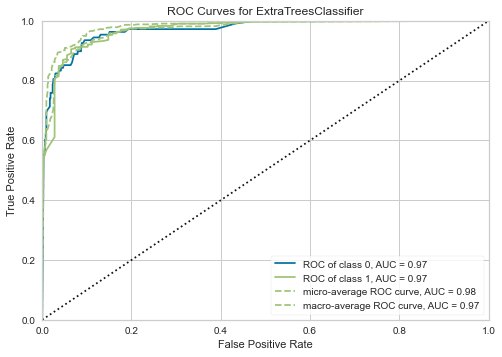

In [21]:
plot_model(model)

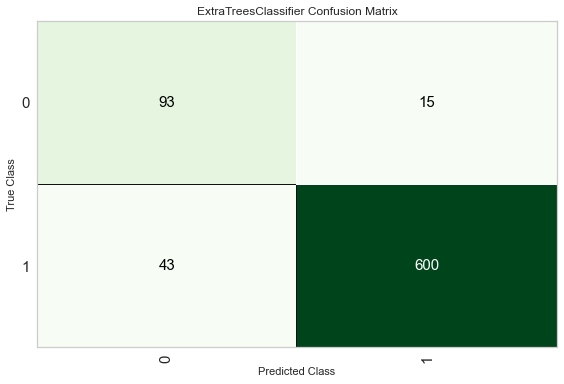

In [22]:
plot_model(model, 'confusion_matrix')

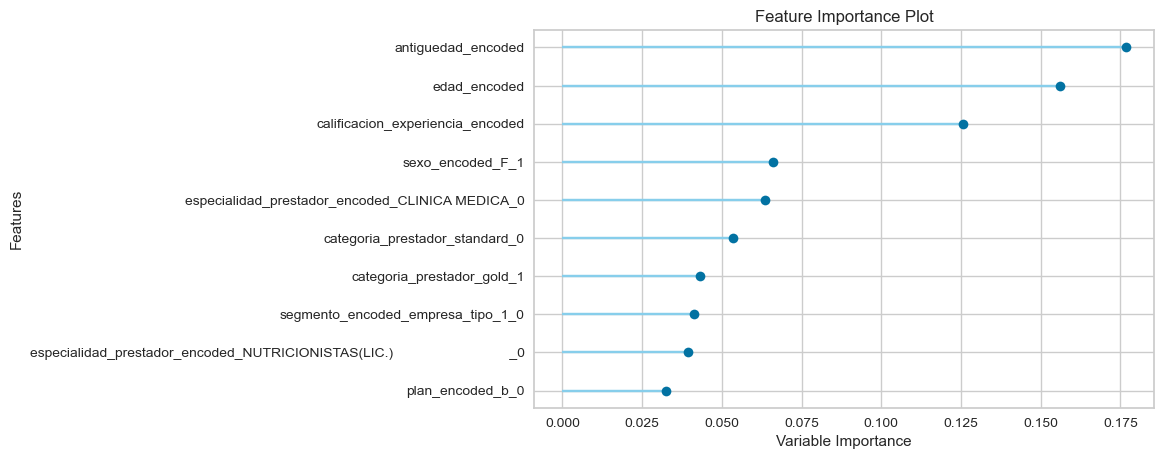

In [23]:
plot_model(model, plot = 'feature')

In [24]:
finalize_model(model)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

# CONSIGNA N° 2

 Desarrollar al menos dos modelos de clasificación (decision tree, logistic regression)que tengan como target feature categoria_prestador.La target feature podrá asumir dos valores:
*  Standard.
* Silver + Gold.
* Aplicar las buenas prácticas en la construcción de modelos: dividir datos en conjunto
de entrenamiento y validación, cross-validation, grid-search.
Obtener feature importance.
Link de interés:
https://machinelearningmastery.com/calculate-feature-importance-with-python/
El objetivo es entender las diferencias entre las distintas categorías de prestadores.
Cuáles son las variables más relevantes para diferenciarlos?
Las conclusiones obtenidas a partir de este modelo resultarán de gran importancia
para el desarrollo de un modelo de recomendación

In [90]:
df_procesado_1=pd.read_csv('../Data/df_procesado.csv')
df_procesado_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   float

In [91]:
features_eliminar = ['id_consumo_encoded','id_prestador_encoded','id_socio_encoded','id_zona_encoded' , 'categoria_prestador_gold','categoria_prestador_silver']
df_procesado_1.drop(features_eliminar, axis = 1,inplace = True)

X_1 = df_procesado_1.drop(['categoria_prestador_standard'], axis = 1)
Y_1 = df_procesado_1.categoria_prestador_standard

X_train_1 , X_test_1 , y_train_1 , y_test_1 = train_test_split(X_1 , Y_1 , test_size = 0.3 , random_state=42)

In [92]:
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 1552 to 860
Data columns (total 24 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   calificacion_experiencia_encoded                                                   1750 non-null   float64
 1   edad_encoded                                                                       1750 non-null   float64
 2   antiguedad_encoded                                                                 1750 non-null   float64
 3   sexo_encoded_F                                                                     1750 non-null   int64  
 4   sexo_encoded_M                                                                     1750 non-null   int64  
 5   plan_encoded_a                                                                     1750 non-null   int

In [93]:
lr_1 = LogisticRegression(random_state = 0, class_weight = 'balanced')
dt_1 = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')

models_parameters_1= {'logistic_regression': (lr_1,
                     {'penalty':['l1','l2'],
                     'C':[0.0001,0.001,0.01,0.1,1,10],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})
                     ,'decision_tree': (dt_1,
                     {'max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'criterion': ['gini','entropy']})}

In [94]:
for name, (model, params) in models_parameters_1.items():

    cv = GridSearchCV(model , cv = 5 , param_grid = params , n_jobs = -1, scoring = 'balanced_accuracy' )

    cv.fit(X_train_1 , y_train_1)
    
    print(name)
    print(cv.best_score_)
    print(cv.best_params_)

logistic_regression
0.8685339222181326
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
decision_tree
0.8892789228315545
{'criterion': 'gini', 'max_depth': 10}


In [104]:
cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [100]:
best_model_1 = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced' , max_depth = 10 , criterion = 'gini' )

best_model_1.fit(X_train_1, y_train_1)

y_pred_train_1 = best_model_1.predict(X_train_1)
y_pred_test_1 = best_model_1.predict(X_test_1)

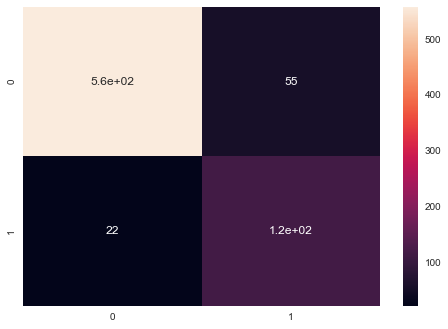

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       612
           1       0.68      0.84      0.75       138

    accuracy                           0.90       750
   macro avg       0.82      0.88      0.84       750
weighted avg       0.91      0.90      0.90       750



In [101]:
cm_1 = confusion_matrix(y_test_1 , y_pred_test_1)

sns.heatmap(cm_1 , annot = True)
plt.show()

print(classification_report(y_test_1 , y_pred_test_1))

In [107]:
importance_1 = best_model_1.feature_importances_
importances_1 = pd.DataFrame({'features': X_train_1.columns , 'importances_1': importance_1})
importances_1.sort_values(by='importances_1',ascending=False, inplace = True)

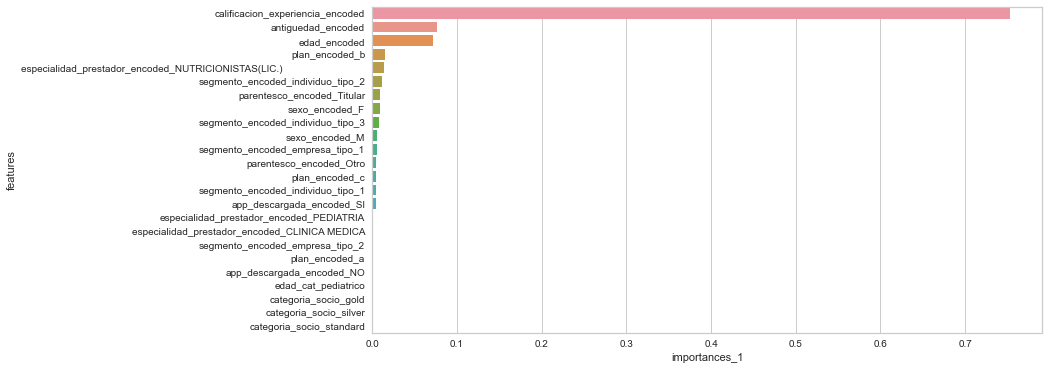

In [108]:
plt.figure(figsize=(12,6))
sns.barplot(data=importances_1, y='features',x='importances_1')
plt.show()